![Py4Eng](img/logo.png)

# Keras Functional API & Autoencoders
## Yoav Ram

The [functional API](https://keras.io/guides/functional_api/) is an advanced Keras feature that is used for building non-sequential networks, such as ResNet, or networks made from mutiple nested models, such as GAN and autoencoders.

In the functional API, each layer is a function that operates on an input to produce an output. These inputs and outputs are *symbolic* and do not contain any data when we set the network up. They will only contain data during training or predicting.

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import tensorflow as tf
try:
    import keras
except ModuleNotFoundError:
    from tensorflow import keras
print('Keras', keras.__version__)
print('GPU:', tf.test.is_gpu_available())
print(tf.test.gpu_device_name())

sns.set(
    style='ticks',
    context='talk',
    palette='Set1'
)

def display_image(im):
    fig, ax = plt.subplots()
    ax.imshow(im, cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])    

Keras 2.3.1
GPU: False



In [22]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
nsamples, width, height = X_train.shape
X_train = (X_train/255).astype('float32')
X_test = (X_test/255).astype('float32')

In [23]:
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

# FFN with `Sequential`

This is the two-layers simple feed forward network we implemented already.

In [24]:
model = keras.models.Sequential()

model.add(
    keras.layers.Flatten(input_shape=(width, height)))
model.add(
    keras.layers.Dense(100, activation='relu'))
model.add(
    keras.layers.Dropout(rate=0.5))
model.add(
    keras.layers.Dense(ncats, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               78500     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [25]:
history = model.fit(x=X_train, y=Y_train, batch_size=50, epochs=5, 
    validation_data=(X_test, Y_test),
).history

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 59us/step - loss: 0.4570 - accuracy: 0.8659 - val_loss: 0.1914 - val_accuracy: 0.9453
Epoch 2/5
60000/60000 [==============================] - 3s 47us/step - loss: 0.2612 - accuracy: 0.9232 - val_loss: 0.1503 - val_accuracy: 0.9565
Epoch 3/5
60000/60000 [==============================] - 3s 50us/step - loss: 0.2184 - accuracy: 0.9354 - val_loss: 0.1210 - val_accuracy: 0.9627
Epoch 4/5
60000/60000 [==============================] - 3s 49us/step - loss: 0.1934 - accuracy: 0.9434 - val_loss: 0.1125 - val_accuracy: 0.9670
Epoch 5/5
60000/60000 [==============================] - 3s 51us/step - loss: 0.1784 - accuracy: 0.9458 - val_loss: 0.1002 - val_accuracy: 0.9702


# FFN with functional API 

We now implement it with the functional API.

In this API, each layer is a function that works on some input tensor. A tensor is basically a placeholder for future data (array).

We first create the layers, then apply them to the tensors. The first tensor is a special `Input` tensor. The model is then created using the input and the output tensors.

In [25]:
x = keras.Input(shape=(width, height))
flatten_layer = keras.layers.Flatten()
hidden_layer = keras.layers.Dense(100, activation="relu")
dropout_layer = keras.layers.Dropout(rate=0.5)
softmax_layer = keras.layers.Dense(ncats, activation="softmax")

x_flat = flatten_layer(x)
h = hidden_layer(x_flat)
h_drop = dropout_layer(h)
yhat = softmax_layer(h_drop)

model = keras.Model(inputs=x, outputs=yhat)
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 28, 28)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               78500     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


The rest is per usual - compile and fit.

In [37]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [38]:
history = model.fit(x=X_train, y=Y_train, batch_size=50, epochs=5, 
    validation_data=(X_test, Y_test),
).history

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 48us/step - loss: 0.4601 - accuracy: 0.8637 - val_loss: 0.1944 - val_accuracy: 0.9420
Epoch 2/5
60000/60000 [==============================] - 3s 44us/step - loss: 0.2600 - accuracy: 0.9232 - val_loss: 0.1461 - val_accuracy: 0.9555
Epoch 3/5
60000/60000 [==============================] - 3s 44us/step - loss: 0.2188 - accuracy: 0.9356 - val_loss: 0.1242 - val_accuracy: 0.9625
Epoch 4/5
60000/60000 [==============================] - 3s 44us/step - loss: 0.1957 - accuracy: 0.9407 - val_loss: 0.1152 - val_accuracy: 0.9642
Epoch 5/5
60000/60000 [==============================] - 3s 51us/step - loss: 0.1782 - accuracy: 0.9467 - val_loss: 0.1063 - val_accuracy: 0.9696


# Exercise

Implement a CNN using the functional API. See the sequenctial example below (copied from [the CNN session](K_CNN.ipynb)).

[solution](../solutions/functional_keras.py)

In [26]:
# Sequential example
model = keras.models.Sequential()

model.add(
    keras.layers.Reshape(target_shape=(width, height, 1), 
                         input_shape=(width, height)))
model.add(
    keras.layers.Conv2D(32, (5, 5), activation='relu'))
model.add(
    keras.layers.MaxPool2D())
model.add(
    keras.layers.Conv2D(64, (5, 5), activation='relu'))
model.add(
    keras.layers.MaxPool2D())
model.add(
    keras.layers.Flatten())
model.add(
    keras.layers.Dense(1024, activation='relu'))
model.add(
    keras.layers.Dropout(rate=0.5))
model.add(
    keras.layers.Dense(ncats, activation='softmax'))

In [28]:
# Functional 
# your code here

################

In [44]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [45]:
history = model.fit(x=X_train, y=Y_train, batch_size=50, epochs=5, 
    validation_data=(X_test, Y_test),
).history

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 2013s 34ms/step - loss: 0.1307 - accuracy: 0.9591 - val_loss: 0.0342 - val_accuracy: 0.9890
Epoch 2/5
60000/60000 [==============================] - 65s 1ms/step - loss: 0.0441 - accuracy: 0.9862 - val_loss: 0.0298 - val_accuracy: 0.9903
Epoch 3/5
60000/60000 [==============================] - 65s 1ms/step - loss: 0.0312 - accuracy: 0.9908 - val_loss: 0.0247 - val_accuracy: 0.9917
Epoch 4/5
60000/60000 [==============================] - 61s 1ms/step - loss: 0.0251 - accuracy: 0.9920 - val_loss: 0.0210 - val_accuracy: 0.9942
Epoch 5/5
60000/60000 [==============================] - 59s 979us/step - loss: 0.0212 - accuracy: 0.9935 - val_loss: 0.0301 - val_accuracy: 0.9906


# Autoencoders

A nice example for the use of the functional API is an autoencoder: a model that encodes an image to its features, and then decoded the features back to the (original) image. This is useful for a variety of applications, such as lossy compression, data generation, and unsupervised feature learning.

![autoencoder](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

We will create a simple autoencoder using FFN, but more examples are [available](https://blog.keras.io/building-autoencoders-in-keras.html).

We start with the encoder, which encodes a 28x28 image to a features vector of length 32.

In [98]:
# this is the size of our encoded representations
# compression of factor 24.5
nfeatures = 32  

encoder = keras.Sequential([
    keras.layers.Flatten(input_shape=(width, height)),
    keras.layers.Dense(nfeatures, activation='tanh')
])

The decoder decoded the features vector back to an image.

In [99]:
decoder = keras.Sequential([
    keras.layers.Dense(width * height, activation='sigmoid', input_shape=(nfeatures,)),
    keras.layers.Reshape(target_shape=(width, height))
])  

Now the autoencoder encodes an image and decoed it back using the encoder and decoder. This is where we apply the functional API.

In [100]:
input_image = keras.Input(shape=(width, height))
encoded = encoder(input_image)
decoded = decoder(encoded)

autoencoder = keras.Model(input_image, decoded)

We compile the autoencoder so we can train it on reconstructing images.

In [101]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Now we train the autoencoder.

In [102]:
history = autoencoder.fit(X_train, X_train, # Y=X
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test)).history

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.3370 - val_loss: 0.2711
Epoch 2/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.2676 - val_loss: 0.2652
Epoch 3/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.2647 - val_loss: 0.2639
Epoch 4/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.2590 - val_loss: 0.2547
Epoch 5/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.2530 - val_loss: 0.2510
Epoch 6/50
60000/60000 [==============================] - ETA: 0s - loss: 0.248 - 2s 36us/step - loss: 0.2481 - val_loss: 0.2435
Epoch 7/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.2411 - val_loss: 0.2389
Epoch 8/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.2366 - val_loss: 0.2313
Epoch 9/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.2278 

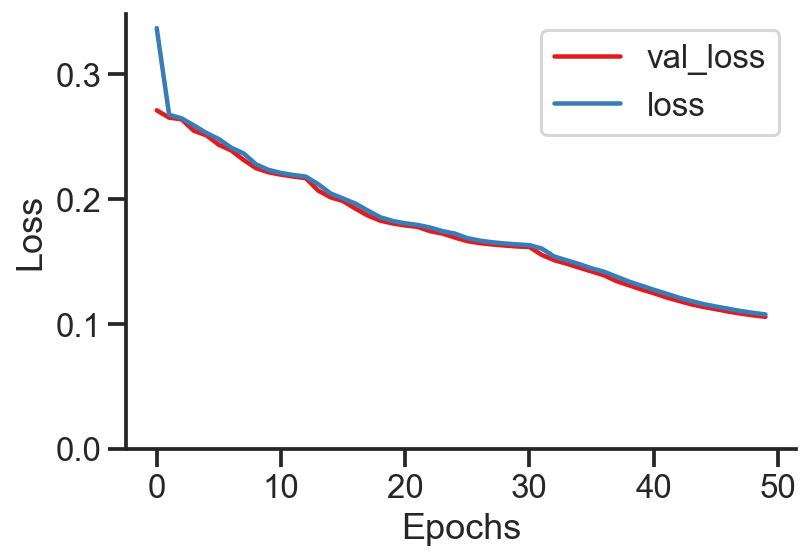

In [103]:
for k in history.keys():
    plt.plot(history[k], label=k)
plt.legend()
plt.ylim(0, None)
plt.xlabel('Epochs')
plt.ylabel('Loss')
sns.despine()

Save the models.

In [104]:
autoencoder.save('../data/autoencoder.h5')
encoder.save('../data/encoder.h5')
decoder.save('../data/decoder.h5')

Load the models.

In [105]:
autoencoder = keras.models.load_model('../data/autoencoder.h5')
encoder = keras.models.load_model('../data/encoder.h5')
decoder = keras.models.load_model('../data/decoder.h5')

Let's see how the autoencoder performs by encoding and decoding some digits.

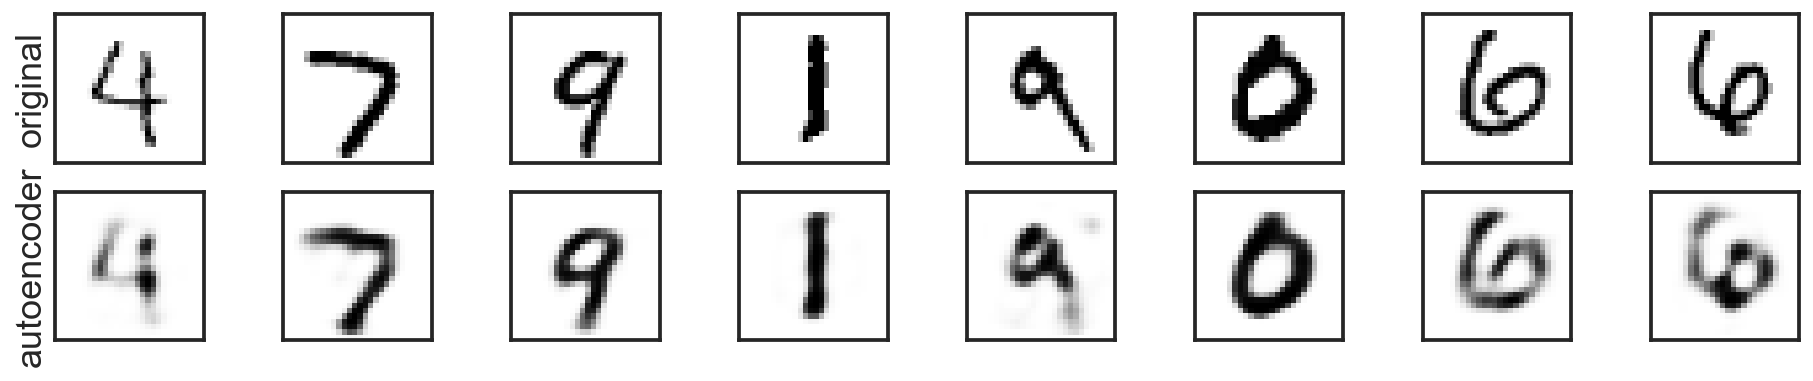

In [106]:
fig, axes = plt.subplots(2, 8, figsize=(16, 3), sharex=True, sharey=True)
for j in range(axes.shape[1]):
    i = np.random.choice(X_test.shape[1])
    im = X_test[i]
    axes[0, j].imshow(im, cmap='gray_r')
    im_ = autoencoder.predict(im.reshape((1, width, height))).squeeze()
    axes[1, j].imshow(im_, cmap='gray_r')
axes[0,0].set(xticks=[], yticks=[], ylabel='original')
axes[1,0].set(ylabel='autoencoder');

We can use the decoder to try to understand the features. We take the features of a specific image and modify them one by one, then decode them and look at the image.
Can you interpret some of the featrues?

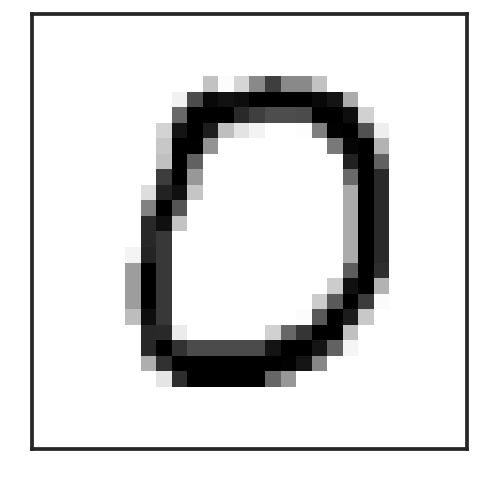

In [138]:
im = X_test[10]
display_image(im)

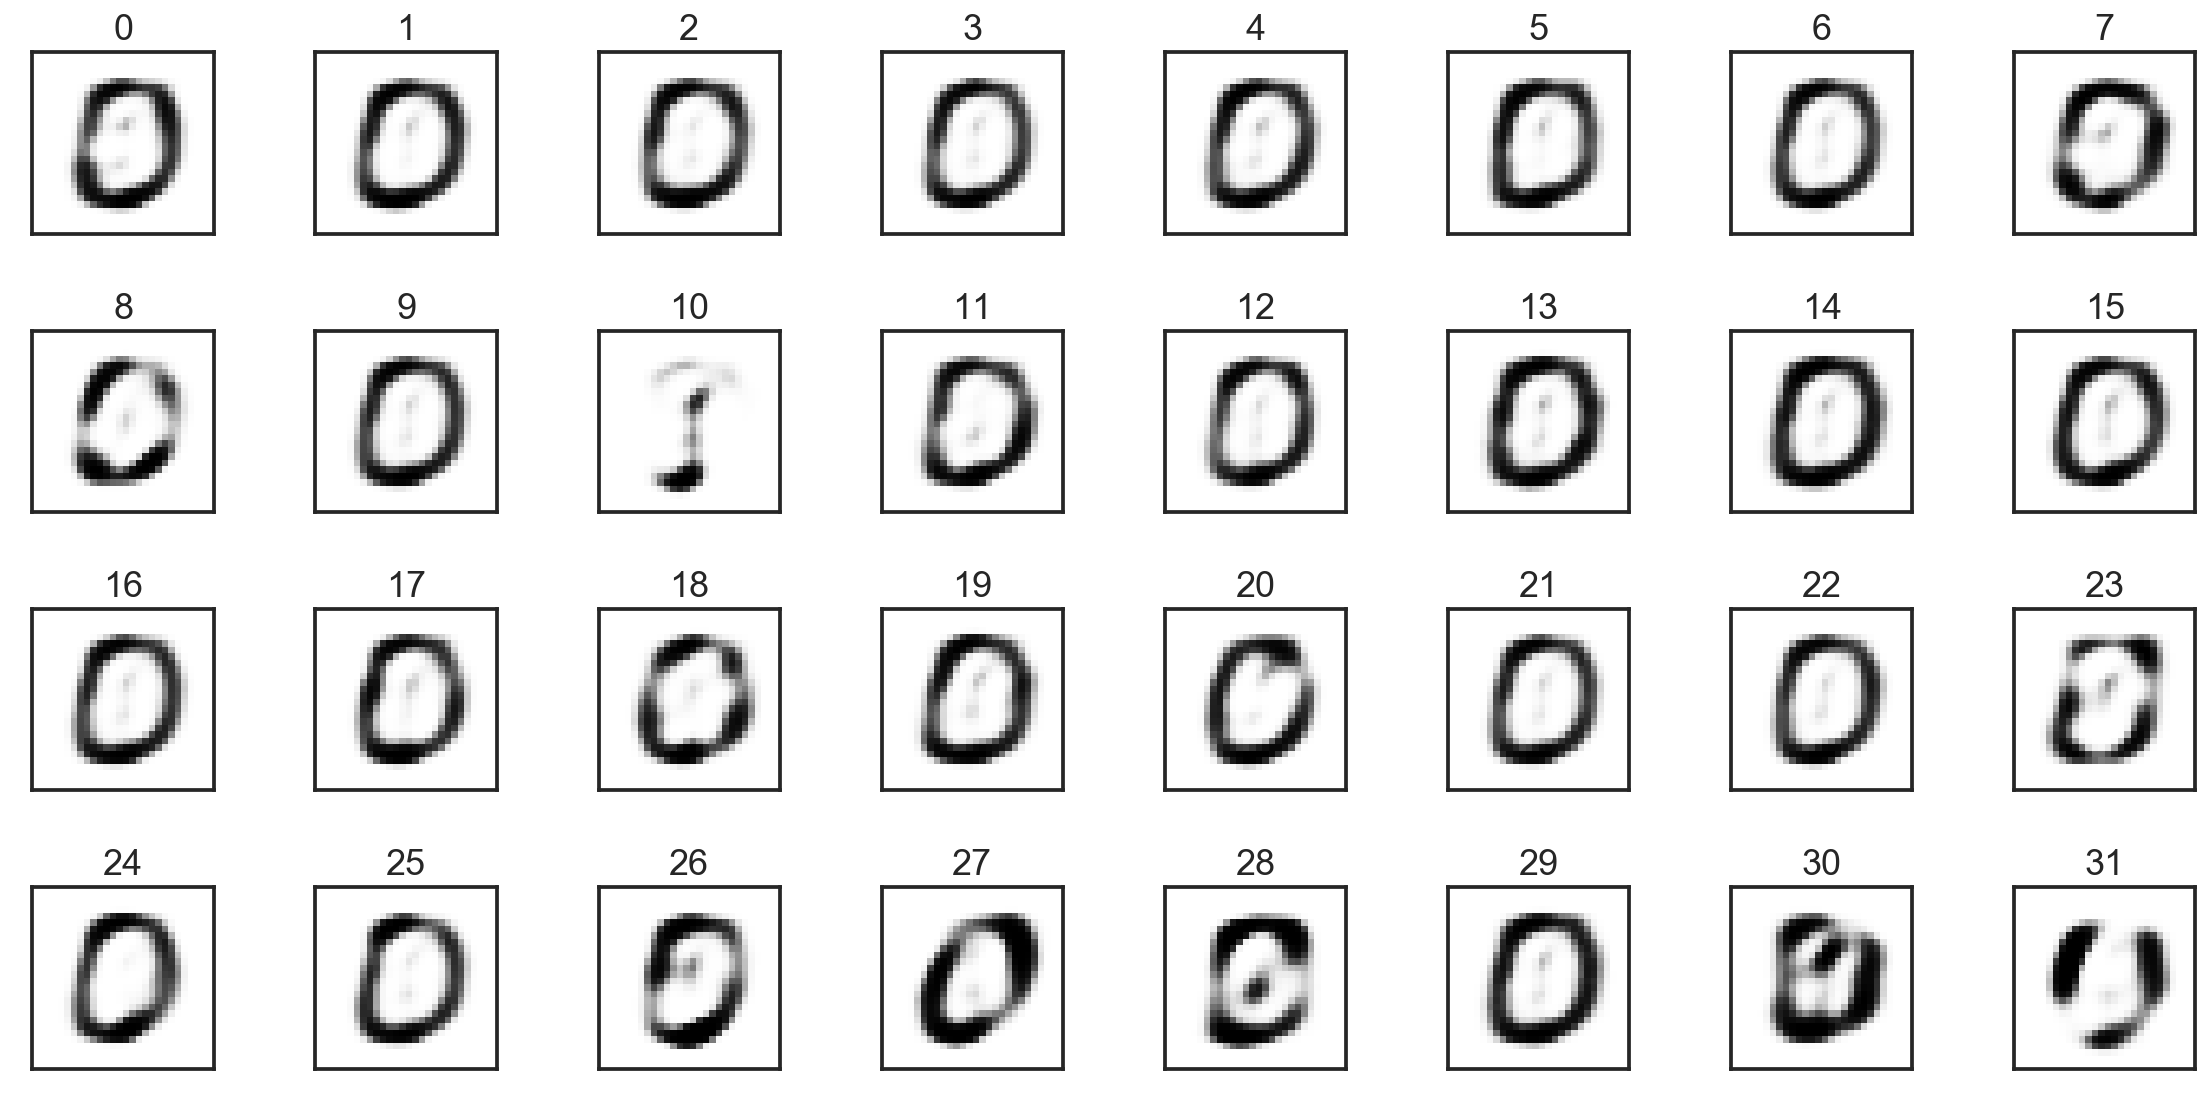

In [143]:
features = encoder.predict(im.reshape((1, width, height)))

fig, axes = plt.subplots(4, 8, figsize=(8*2, 4*2), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    features_ = features.copy()
    features_[0, i] = 1
    im_ = decoder.predict(features_).squeeze()
    ax.imshow(im_, cmap='gray_r')
    ax.set_title(i)
axes[0,0].set(xticks=[], yticks=[])
fig.tight_layout()

Autoencoders can be used for denoising; but in this case it would be better to train the autoencoder on denoising, that is, on reconstructing X from noisy X.

In [168]:
X_noise = X_test[:8] + np.random.normal(loc=0.0, scale=0.1, size=X_test[:8].shape) 
X_noise = X_test[:8].copy() 
r = np.random.random(X_noise.shape)
X_noise[r <= 0.02] = 0
X_noise[(0.02 < r) & (r <= 0.04)] = 1
X_denoised = autoencoder.predict(X_noise)

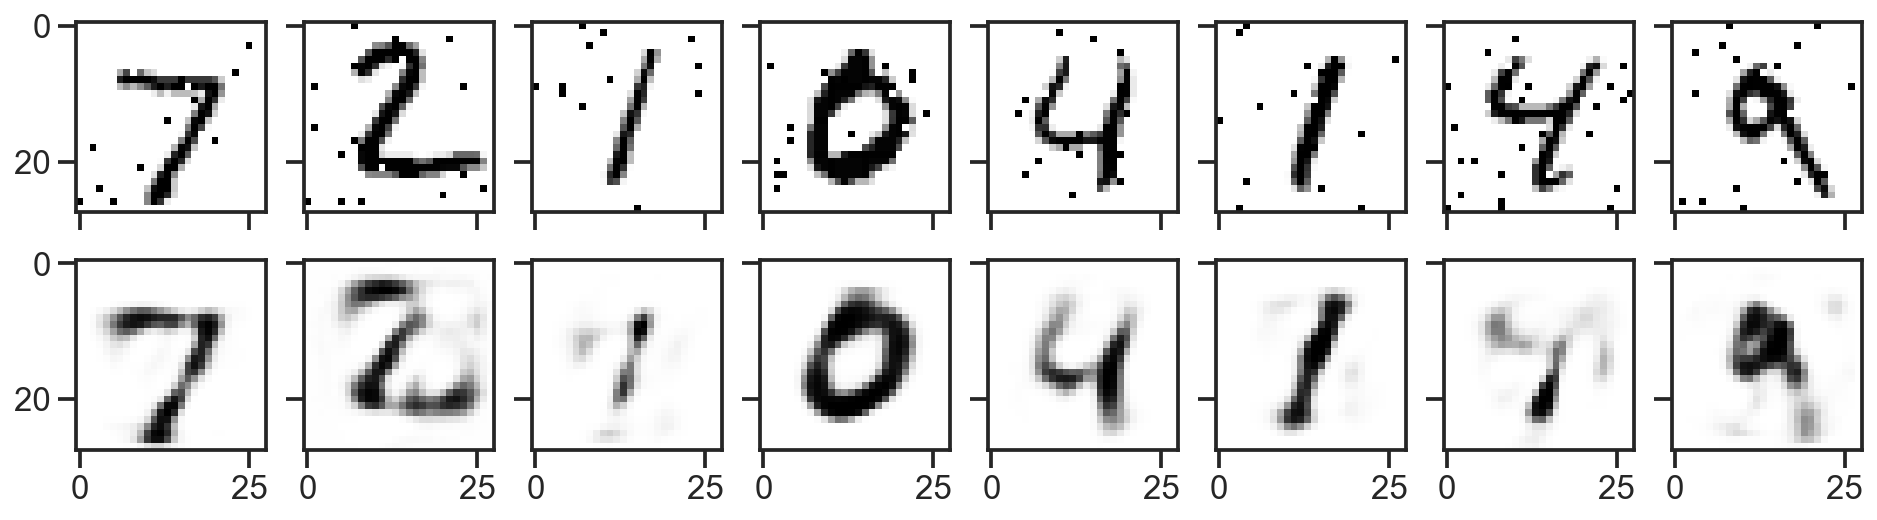

In [169]:
fig, axes = plt.subplots(2, X_noise.shape[0], figsize=(16, 4), sharex=True, sharey=True)
for j in range(X_noise.shape[0]):
    axes[0, j].imshow(X_noise[j], cmap='gray_r')
    axes[1, j].imshow(X_denoised[j], cmap='gray_r')

Another use for autoencoders is if we had many images (X) but only had labels (Y) for a few images. In this case we could learn how to encode images to features (i.e. train an encoder) using all the image data, and then compose a classifier on top of the encoder and train it with the limited number of labels we have.

# References

- [Keras functional API](https://keras.io/guides/functional_api/)
- Keras autoencoders [examples](https://blog.keras.io/building-autoencoders-in-keras.html).
- [Variational autoencoders explained](http://ruishu.io/2018/03/14/vae/)

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

The notebook was written using [Python](http://python.org/) 3.7.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)